In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from tree_extraction.Aho import get_ratio_matrix

In [12]:
class SharedCalc(object):
    def _init_all(self):
        if not hasattr(self, "verbose"):
            self.verbose = False
        self._init_graph()
        self._init_sum_alphas()
        self._init_matrices()
        self._init_diffs()
    
    @classmethod
    def get_offset(cls, b, factor = 10):
        offset = factor
        while np.max(b) + 1 >= offset:
            offset *= factor
        return offset

    def _init_graph(self):
        s2 = self.s2
        b = self.b
        alphas_by_depth = self.alphas_by_depth
        offset = self.offset

        triplet = [0, 0, 0]

        alphas = dict()
        g = nx.DiGraph()
        g.graph["root"] = 0
        for i in range(len(b)):
            for j in range(b[i]):
                srcIndex = i * offset
                dstIndex = j + (i + 1) * offset
                g.add_edge(srcIndex, dstIndex)
                alphas[dstIndex] = alphas_by_depth[i]
                if i == 0 and j == b[i] - 1:
                    triplet[2] = dstIndex
                if i == s2 and j == 1:
                    triplet[0] = dstIndex
                if i == s2 and j == 2:
                    triplet[1] = dstIndex
                if i == s2 and s2 == len(b) - 1 and j == 0:
                    triplet[1] = dstIndex
                    
        self.g = g
        self.triplet = triplet
        self.alphas = alphas
        
    def _init_matrices(self):
        self.R, lp = compute_combo_tensor_pam(self.g,
            alpha = IndividualNodeAlphaCalc(self.g, self.alphas),
            return_leaf_paths = True)
        self.C = get_ratio_matrix(self.R)
        
        self.leaves = [p[-1] for p in lp]
        self.leaf_to_index = {k: i for i, k in enumerate(self.leaves)}
        
    def _init_diffs(self):
        C = self.C

        dropped_diagonal = []
        for i in range(C.shape[0]):
            sortedRow = sorted(list(C[i, :i]) + list(C[i, i+1:]))
            dropped_diagonal.append(sortedRow)
        dropped_diagonal = np.array(dropped_diagonal).round(decimals = 10)
        diffs = np.diff(dropped_diagonal, axis=1)
        unique_values = np.unique(dropped_diagonal)
        min_diff = np.min(np.diff(unique_values))

        self.dropped_diagonal = dropped_diagonal
        self.diffs = diffs
        self.unique_values = unique_values
        self.min_diff = min_diff
        
        i, j, k = [self.leaf_to_index[self.triplet[m]] for m in range(3)]
        self.triplet_diff = self.C[i, j] - self.C[i, k]
        
    def _init_sum_alphas(self):
        result = dict()
        for n in self.g.nodes():
            nbrs = list(self.g.neighbors(n))
            if len(nbrs) == 0:
                continue
            result[n] = np.sum([self.alphas[x] for x in nbrs])
        self.sum_alphas = result
        
        delta_dict = dict()
        for n in self.g.nodes():
            if n in self.alphas and n in self.sum_alphas:
                # Note: `alphas` corresponds to parent->n, whereas `sum_alphas` corresponds to n->children
                delta_dict[n] = self.sum_alphas[n] - self.alphas[n]
        self.observed_dmin = np.min(list(delta_dict.values()))
        self.delta_dict = delta_dict

In [13]:
class Analysis1(SharedCalc):
    def __init__(self, s1, s2, b, dmin, alpha0):
        self.s1 = s1
        self.s2 = s2
        self.b = b
        self.dmin = dmin
        self.alpha0 = alpha0
        self.alphas_by_depth = self.get_alphas_by_depth()
        self.offset = self.get_offset(b)
        self._init_all()

    def get_alphas_by_depth(self):
        alphas_by_depth = [self.alpha0]
        for i in range(len(self.b) - 1):
            a = (self.dmin + alphas_by_depth[-1]) / self.b[i+1]
            alphas_by_depth.append(a)
        alphas_by_depth = np.array(alphas_by_depth, dtype='float')
        return alphas_by_depth

In [14]:
analysis_specs = [
    dict(s1 = 0, s2 = 1, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    #dict(s1 = 0, s2 = 2, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    #dict(s1 = 0, s2 = 3, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([2,2]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([2,100]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([100,2]), dmin = 0.1, alpha0 = 1.0),
]
for spec in analysis_specs:
    print("#" * 20)
    print(spec)
    a = Analysis1(**spec)
    #nice_tree_plot(a.g)
    #plt.show()
    print("triplet:", a.triplet)
    print("sum_alphas:", a.sum_alphas)
    #print("alphas:", a.alphas)
    print("observed dmin:", a.observed_dmin)
    print("min diff:    ", a.min_diff)
    print("example diff:", a.triplet_diff)

####################
{'s1': 0, 's2': 1, 'b': array([3, 4, 5, 6]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [21, 22, 12]
sum_alphas: {0: 3.0, 10: 1.1, 20: 0.375, 30: 0.175}
observed dmin: 0.09999999999999998
min diff:     0.035714285700000015
example diff: 0.035714285714285254
####################
{'s1': 0, 's2': 1, 'b': array([2, 2]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [21, 20, 11]
sum_alphas: {0: 2.0, 10: 1.1}
observed dmin: 0.10000000000000009
min diff:     0.03174603170000001
example diff: 0.03174603174603163
####################
{'s1': 0, 's2': 1, 'b': array([  2, 100]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [2001, 2002, 1001]
sum_alphas: {0: 2.0, 1000: 1.0999999999999994}
observed dmin: 0.09999999999999942
min diff:     0.03174603170000001
example diff: 0.03174603174603219
####################
{'s1': 0, 's2': 1, 'b': array([100,   2]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [2001, 2000, 1099]
sum_alphas: {0: 100.0, 1000: 1.1}
observed dmin: 0.10000000000000009
min diff:     0.047147571

## Alternate analysis

In [15]:
class Analysis2(SharedCalc):
    def __init__(self, s1, s2, b, alpha):
        self.s1 = s1
        self.s2 = s2
        self.b = b
        self.alphas_by_depth = alpha
        self.offset = self.get_offset(b)
        self._init_all()

####################
{'s1': 0, 's2': 1, 'b': array([2, 2]), 'alpha': array([0.01, 1.  ])}


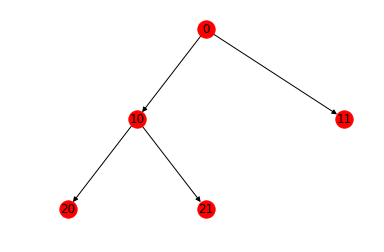

triplet: [21, 20, 11]
sum_alphas: {0: 0.02, 10: 2.0}
alphas: {10: 0.01, 11: 0.01, 20: 1.0, 21: 1.0}
observed dmin: 1.99
observed deltas: {10: 1.99}
min diff:     1.3006535948
example diff: 1.3006535947712423


In [24]:
analysis_specs = [
    #dict(s1 = 0, s2 = 1, b = np.array([3,4,5,6]), alpha = np.array([1, 1, 1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 2, b = np.array([2,2,2]), alpha = np.array([3, 3.5, 1])),
    dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([1/100,1])),
    #dict(s1 = 0, s2 = 1, b = np.array([3,4]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([10, 10], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,100]), alpha = np.array([10, .00001], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,100]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([100,2]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([100,100]), alpha = np.array([1, 1], dtype='float')),
]
for spec in analysis_specs:
    print("#" * 20)
    print(spec)
    a = Analysis2(**spec)
    nice_tree_plot(a.g)
    plt.show()
    print("triplet:", a.triplet)
    print("sum_alphas:", a.sum_alphas)
    print("alphas:", a.alphas)
    print("observed dmin:", a.observed_dmin)
    print("observed deltas:", a.delta_dict)
    print("min diff:    ", a.min_diff)
    print("example diff:", a.triplet_diff)

In [26]:
a.C

array([[1.98039216, 0.01960784, 0.01960784],
       [0.01960784, 2.64052288, 1.32026144],
       [0.01960784, 1.32026144, 2.64052288]])

In [112]:
def fz(b0, b1, a0, a1):
    return b0 / (1 + b0*a0) * ((b1*a1 - a0) / (1 + b1*a1))

In [113]:
fz(2,2,1,1)

0.2222222222222222

In [114]:
fz(2,7,1,1/7)

0.0

In [115]:
fz(2,200,1/100,1)

1.9509316164276658

In [116]:
fz(2,2,1/100,1)

1.3006535947712419

In [30]:
from scipy.optimize import minimize

In [124]:
dmin = 1.0
alpha_max = 1.0

def f(x):
    a1, a2, a3, a4 = x
    return (a1 + a2) / (1 + a1 + a2) * ((a3 + a4) * (1 + a1) / ((1 + a3 + a4) * (a1)) - 1)

def c1(x, dmin):
    a1, a2, a3, a4 = np.atleast_2d(x).transpose()
    r = a3 + a4
    r = r - a1
    r = r - dmin
    return r

def c2(x, i, alpha_max):
    return alpha_max - np.asarray(x)[..., i]

constrs = [
    dict(fun=c1, type='ineq', args=(dmin,))
]

def mk_constr(index):
    return lambda x: np.asarray(x)[..., index]

for i in range(4):
    zz = mk_constr(i)
    constrs.append(dict(fun=zz, type='ineq'))
    constrs.append(dict(fun=c2, type='ineq', args=(i, alpha_max)))

for i, c in enumerate(constrs):
    print(c)
    print('   ', c['fun']([10,20,30,40], *c.get('args', ())))

{'fun': <function c1 at 0x1135939d8>, 'type': 'ineq', 'args': (1.0,)}
    [59.]
{'fun': <function mk_constr.<locals>.<lambda> at 0x113593d90>, 'type': 'ineq'}
    10
{'fun': <function c2 at 0x113593400>, 'type': 'ineq', 'args': (0, 1.0)}
    -9.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x113593b70>, 'type': 'ineq'}
    20
{'fun': <function c2 at 0x113593400>, 'type': 'ineq', 'args': (1, 1.0)}
    -19.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x113593620>, 'type': 'ineq'}
    30
{'fun': <function c2 at 0x113593400>, 'type': 'ineq', 'args': (2, 1.0)}
    -29.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x113593ae8>, 'type': 'ineq'}
    40
{'fun': <function c2 at 0x113593400>, 'type': 'ineq', 'args': (3, 1.0)}
    -39.0


In [125]:
sol = minimize(f, x0 = [1,1,1,1], constraints=constrs, method='SLSQP')

In [126]:
print(sol.message)
print(sol.fun)
sol.x

Optimization terminated successfully.
0.16666666666666655


array([1., 0., 1., 1.])

In [127]:
f(sol.x)

0.16666666666666655

In [131]:
f([1,1e-5,1,1])

0.16666749999583333